In [1]:
from utils.data_preparation import prepare_dataset

train, val, test = prepare_dataset()

Loading of the train-clean-100 subset...
Loading of the train-clean-100 subset completed.
Volumes - Train: 0.6 | Val: 0.2 | Test: 0.2


In [2]:
from utils.visualize import Visualizer

viz = Visualizer()


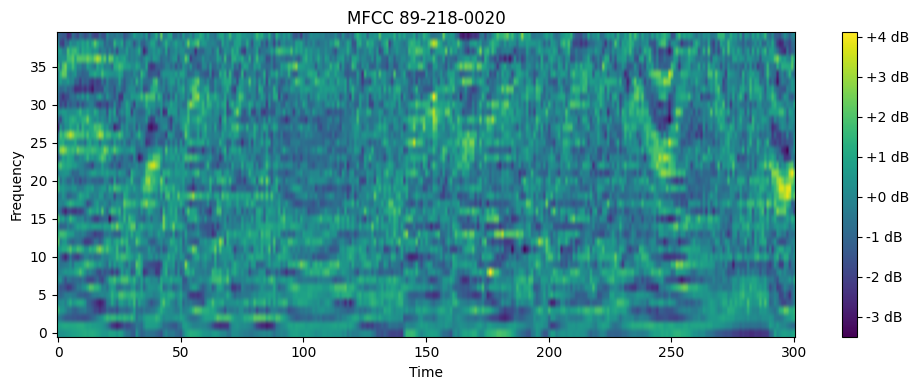

In [3]:
i = 0

feature, _ = train[i]

plot_label = train.get_path(i).split('\\')[-1].split('.')[0]
viz.visualize_features(feature, label=plot_label)

In [4]:
from train import train_model

model, train_metrics, val_metrics, history, y_true, y_pred = train_model(epoch_details=False)
val_metrics

Using device: cpu
Loading of the train-clean-100 subset...
Loading of the train-clean-100 subset completed.
Volumes - Train: 0.6 | Val: 0.2 | Test: 0.2


Training: 100%|██████████| 20/20 [00:31<00:00,  1.58s/epoch]

Training completed.


{'accuracy': 0.5,
 'precision': 0.42000000000000004,
 'recall': 0.5,
 'f1': 0.4333333333333333}

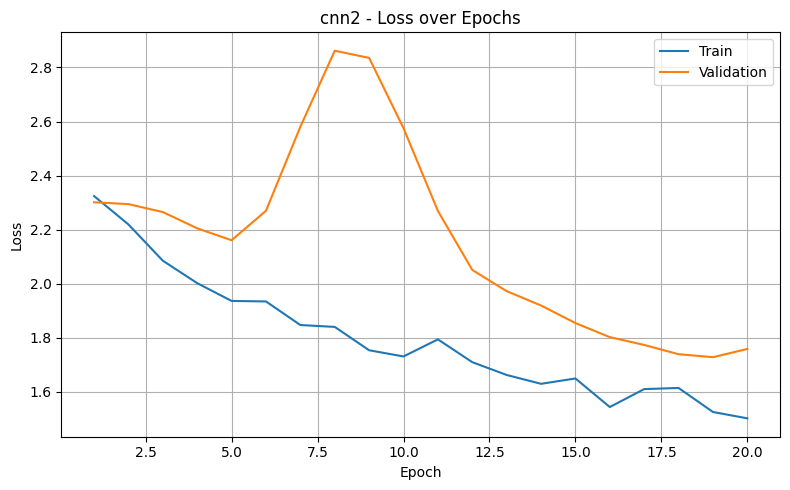

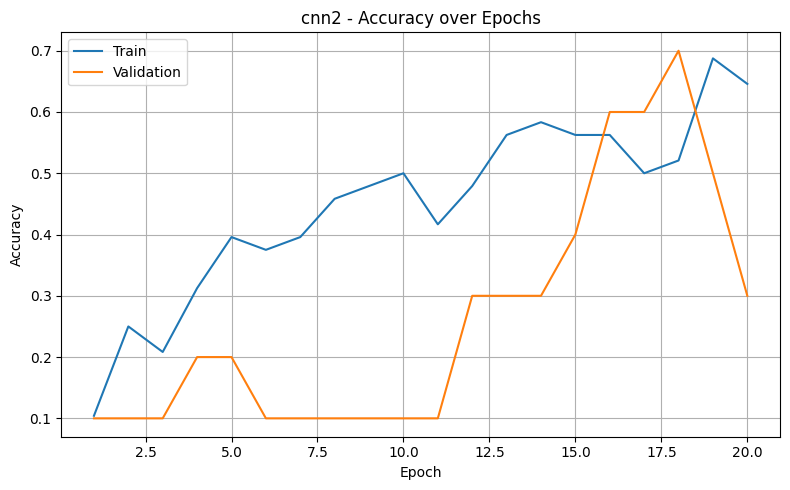

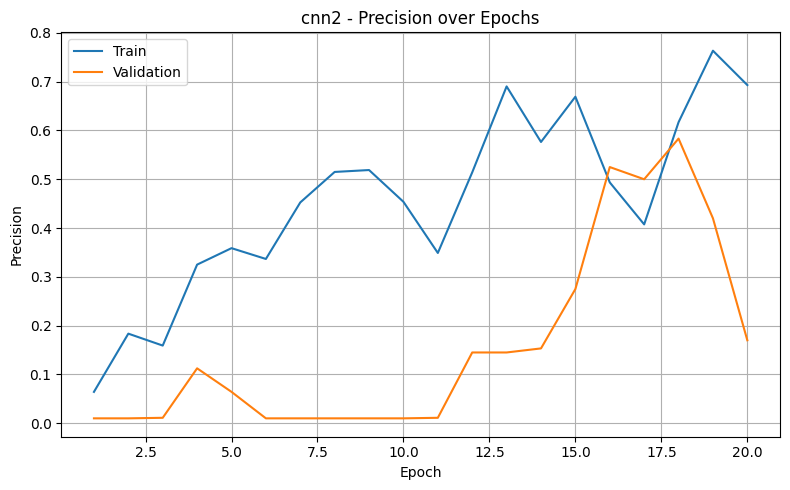

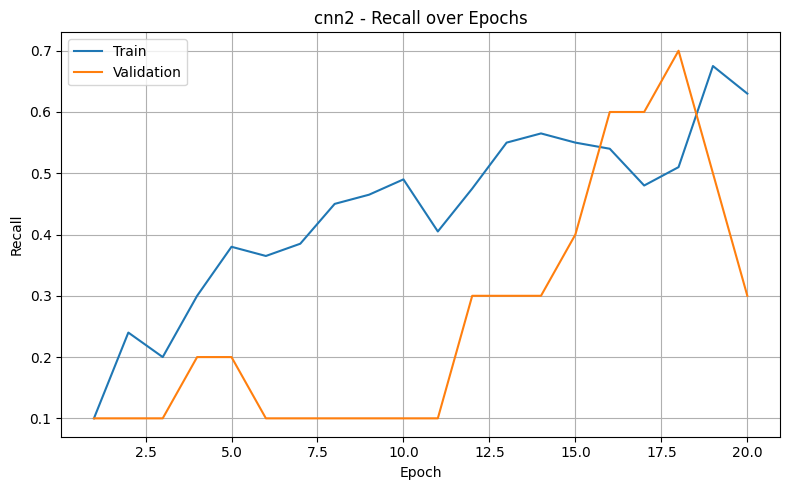

In [5]:
from config import config

viz.plot_training_history(history, metrics=["loss", "accuracy", "precision", "recall"], title_prefix=f"{config['model_type']} - ")

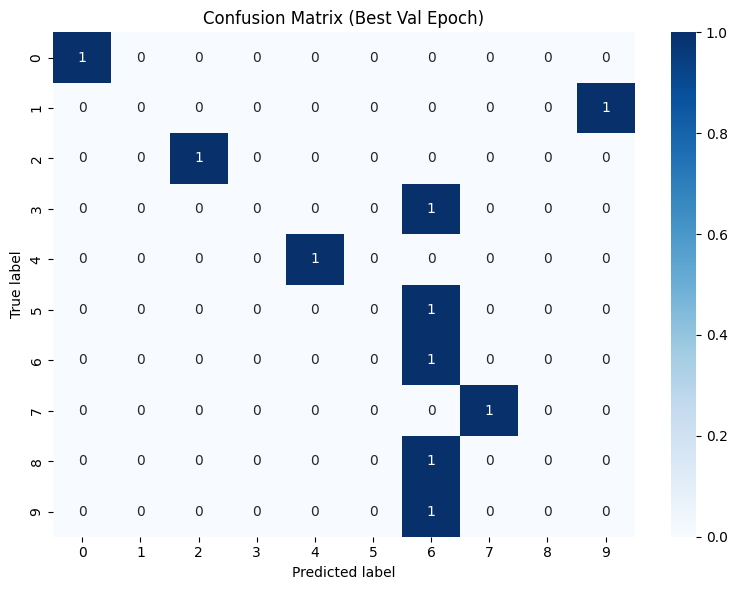

In [6]:
# Visualisation de la matrice de confusion
viz.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=[str(i) for i in range(config['num_speakers'])],
    title="Confusion Matrix (Best Val Epoch)"
)